In [329]:
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import numpy as np
import odf
import math
import pdfkit
from itertools import chain
from statistics import mean
from uncertainties import ufloat, ufloat_fromstr
from sklearn.linear_model import LinearRegression
from lmfit.models import LorentzianModel
from IPython.display import display, Latex
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

X = "Time [$s$]"
Y = "Voltage [$V$]"
ref = 1.63

### Monitoring of Laser Stability

In [127]:
f = codecs.open('1_HeNe.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
HeNe = pd.read_csv('new.txt', skiprows=5, usecols=[0, 1], names=[X, Y])
HeNe.style.set_caption("For HeNe Laser")

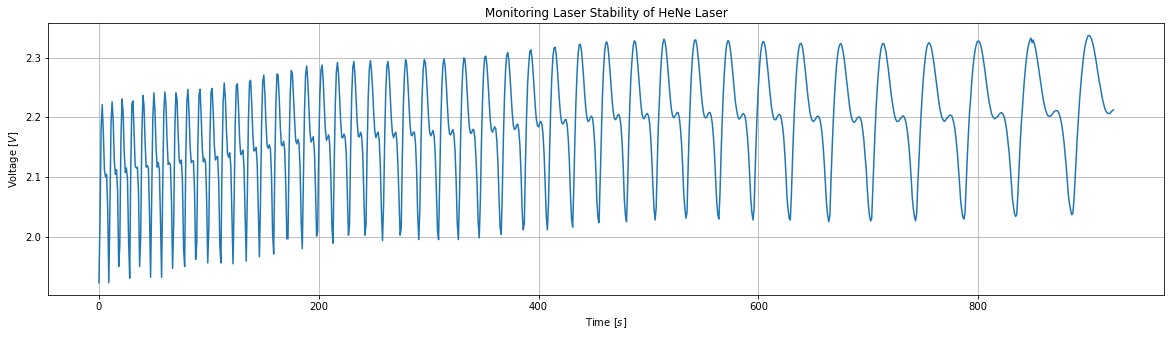

In [122]:
plt.figure(figsize=(20,5))
plt.plot(np.array(HeNe[X]), np.array(HeNe[Y]))
plt.xlabel(X)
plt.ylabel(Y)
plt.title("Monitoring Laser Stability of HeNe Laser")
plt.grid()
plt.show()

In [132]:
f = codecs.open('1_green.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p1green = pd.read_csv('new.txt', skiprows=5, usecols=[0, 1], names=[X, Y])
p1green.style.set_caption("For Green Laser")

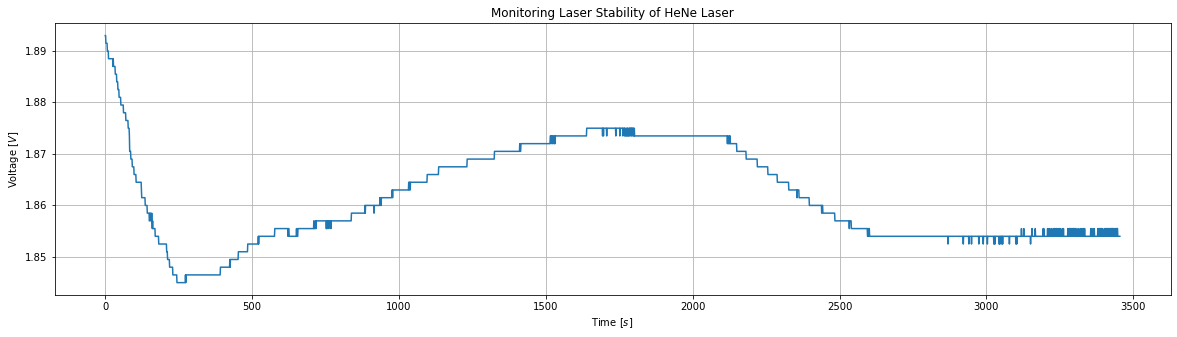

In [134]:
plt.figure(figsize=(20,5))
plt.plot(np.array(p1green[X]), np.array(p1green[Y]))
plt.xlabel(X)
plt.ylabel(Y)
plt.title('Monitoring Laser Stability of HeNe Laser')
plt.grid()
plt.show()

In [141]:
f = codecs.open('1_background.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
background = pd.read_csv('new.txt', skiprows=5, usecols=[0, 1], names=[X, Y])
display(Latex('Background Signal measured ${:10.4f} \ V$'.format(background[Y].mean())))

<IPython.core.display.Latex object>

### Polarization direction of green laser and Malus Law

In [330]:
X = "$𝜃$"
Y = "Voltage [$V$]"
Z = "Normalized Voltage [$V$]"
BackOff = background[Y].mean()
angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=[X])

In [167]:
f = codecs.open('2_-90to90.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p2a = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=[Y])
p2a = pd.concat([df, p2a], axis=1)

In [168]:
p2a[Z] = p2a[Y] - BackOff
A = np.array(p2a[X]).reshape(-1, 1)
B = np.array(p2a[Z]).reshape(-1, 1)
p2a.style.set_caption("Photodiode Signal when illuminated by green laser")

In [160]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

p_objt = linelikeexcel(np.array(df[X]), np.array(p2a[Z]))

x_line = np.linspace(min(np.array(df[X])), max(np.array(df[X])), 100)
y_linet = p_objt(x_line)

plt.plot(np.array(df[X]), np.array(p2a[Z]), 'o')
plt.plot(x_line,y_linet, 'r--')
plt.xlabel(X)
plt.ylabel(Z)
plt.title('Normalized Photodiode Signal vs Orientation angle of the Analyzer in degrees.')

plt.grid()
plt.show()

#### From graph, maximum angle was measured to be, $\alpha = -32.8^{\circ}$.

In [174]:
max_angle = -32.8
p2a['$φ$'] = max_angle - p2a[X]
p2a['$cos^2φ$'] = (np.cos(np.deg2rad(p2a['$φ$'])))**2
p2a

$𝜃$  Voltage [$V$]  Normalized Voltage [$V$]    $φ$  $cos^2φ$
0   -90         0.4245                   0.42735   57.2  0.293448
1   -80         0.6240                   0.62685   47.2  0.461640
2   -70         0.8250                   0.82785   37.2  0.634460
3   -60         1.0140                   1.01685   27.2  0.791061
4   -50         1.1625                   1.16535   17.2  0.912557
5   -40         1.2435                   1.24635    7.2  0.984292
6   -30         1.2570                   1.25985   -2.8  0.997614
7   -20         1.2045                   1.20735  -12.8  0.950916
8   -10         1.0875                   1.09035  -22.8  0.849832
9     0         0.9135                   0.91635  -32.8  0.706552
10   10         0.7080                   0.71085  -42.8  0.538360
11   20         0.4980                   0.50085  -52.8  0.365540
12   30         0.3195                   0.32235  -62.8  0.208939
13   40         0.1800                   0.18285  -72.8  0.087443
14   50         0.0990                   0.10185  -82.8  0.015708
15   60         0.0840                   0.08685  -92.8  0.002386
16   70         0.1410                   0.14385 -102.8  0.049084
17   80         0.2640                   0.26685 -112.8  0.150168
18   90         0.4305                   0.43335 -122.8  0.293448

In [175]:
B = np.array(p2a[Z]).reshape(-1, 1)
A = np.array(p2a['$cos^2φ$']).reshape(-1, 1)
reg = LinearRegression().fit(A, B)
Y_pred = reg.predict(A)
reg_value = reg.score(A, B)
intercept = reg.intercept_
coef = reg.coef_
error = np.sqrt((1/(p2a[X].describe().loc['count'] - 2)) * (1 - ((reg_value) ** 2))/((reg_value) ** 2)) * coef

plt.scatter(A, B)
plt.plot(A, Y_pred, color='blue')
plt.xlabel('$cos^2φ$')
plt.ylabel('Normalized Voltage $[V]$')
plt.grid()
plt.show()
display(Latex("$R^2$ = {:10.8f}".format(reg_value)))
display(Latex("$f(x) = {:10.3f}x  + {:10.2f}$".format(coef[0, 0], intercept[0])))
display(Latex("$\Delta m = {:10.7f}$".format(error[0][0])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Fresnel's reflection coefficients and Brewester angle

In [180]:
Brewster_angle = np.rad2deg(np.arctan(ref))
np.format_float_positional(Brewster_angle, precision=4, unique=False, fractional=False, trim='k')
display(Latex('Calculated value of Brewster angle for refractive index $n = 1.63 \ is \ {:10.2f}^\circ$'.format(Brewster_angle)))

<IPython.core.display.Latex object>

In [336]:
angles = np.array([i for i in range(15, 52, 5)] + [i for i in range(53, 64)] + [i for i in range(65, 90, 5)])
df = pd.DataFrame(data=angles, columns=[X])

#### For s-polarization

In [276]:
f = codecs.open('3d_s_primary.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
sprimarypd = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=[Y])
sprimary = sprimarypd[Y].mean()
def calc_rsp(inci):
    r_sp =  ((np.sqrt(ref**2 - (np.sin(np.deg2rad(inci)))**2) - np.sqrt(1 - (np.sin(np.deg2rad(inci)))**2))**2)/(ref**2 - 1)
    return r_sp

theoreticalr = np.array([calc_rsp(i) for i in angles])
st = pd.DataFrame(data=theoreticalr, columns=['rt'])

rt
0   0.249838
1   0.258159
2   0.269274
3   0.283520
4   0.301333
5   0.323268
6   0.350010
7   0.382399
8   0.404956
9   0.413049
10  0.421446
11  0.430156
12  0.439189
13  0.448557
14  0.458271
15  0.468341
16  0.478780
17  0.489599
18  0.500811
19  0.524461
20  0.591347
21  0.670669
22  0.764147
23  0.873441

In [277]:
f = codecs.open('3d_s.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p3s1 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['$I_r [V]$'])

In [278]:
p3s = pd.concat([df, p3s1], axis=1)
p3s['$r^\perp$'] = np.sqrt(p3s['$I_r [V]$']/sprimary)
p3s

$𝜃$  $I_r [V]$  $r^\perp$
0    15     0.0510   0.219919
1    20     0.0645   0.247318
2    25     0.0705   0.258566
3    30     0.0765   0.269344
4    35     0.0900   0.292145
5    40     0.0930   0.296974
6    45     0.1050   0.315552
7    50     0.1215   0.339441
8    53     0.1335   0.355809
9    54     0.1380   0.361756
10   55     0.1425   0.367607
11   56     0.1500   0.377157
12   57     0.1515   0.379038
13   58     0.1530   0.380910
14   59     0.1560   0.384626
15   60     0.1620   0.391953
16   61     0.1665   0.397360
17   62     0.1695   0.400924
18   63     0.1800   0.413155
19   65     0.2055   0.441451
20   70     0.2580   0.494637
21   75     0.3210   0.551733
22   80     0.4035   0.618584
23   85     0.5745   0.738111

In [323]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

p_objs = linelikeexcel(np.array(df[X]), np.array(p3s['$r^\perp$']))
p_objst = linelikeexcel(np.array(df[X]), np.array(st['rt']))

x_line = np.linspace(min(df[X]), max(df[X]), 100)
y_lines = p_objs(x_line)
y_linest = p_objst(x_line)

plt.plot(df[X], p3s['$r^\perp$'], 'o', color='blue', label='Measured')
plt.plot(df[X], st['rt'], 'o', color='orange', label='calculated')
plt.plot(x_line,y_lines, 'r--', color='green') 
plt.plot(x_line, y_linest, 'r--')
plt.title('For s-polarization')
plt.xlabel('$𝜃 \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')

plt.legend()
plt.grid()
plt.show()

KeyError: 'Voltage'

#### For p-polarization

In [285]:
f = codecs.open('3_p_primary.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
pprimarypd = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=[Y])
pprimary = pprimarypd[Y].mean()
def calc_rpp(inci):
    r_pp = (((ref**2)*(np.sqrt(1 - (np.sin(np.deg2rad(inci)))**2))) - (np.sqrt(ref**2 - (np.sin(np.deg2rad(inci)))**2)))/((ref**2)*(np.sqrt(1 - (np.sin(np.deg2rad(inci)))**2)) + (np.sqrt(ref**2 - (np.sin(np.deg2rad(inci)))**2)))
    return r_pp

theoreticalr = np.array([calc_rpp(i) for i in angles])
pt = pd.DataFrame(data=np.abs(theoreticalr), columns=['rt'])

In [286]:
f = codecs.open('3_p.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p3p1 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['$I_r [V]$'])
p3p1['$I_r [V]$'] = p3p1['$I_r [V]$'] - background[Y].mean()

In [287]:
p3p = pd.concat([df, p3p1], axis=1)
p3p['$r^\parallel$'] = np.sqrt(p3p['$I_r [V]$']/pprimary)
p3p.style.set_caption("Background offset has been substracted")

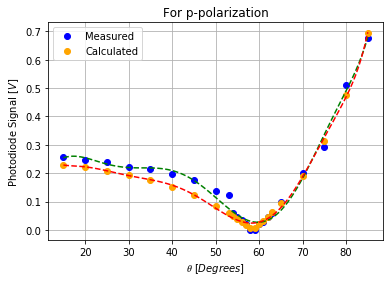

In [293]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

p_objp = linelikeexcel(df[X], p3p['$r^\parallel$'])
p_objpt = linelikeexcel(df[X], pt['rt'])

x_line = np.linspace(min(df[X]), max(df[X]), 100)
y_linep = p_objp(x_line)
y_linept = p_objpt(x_line)

plt.plot(df[X], p3p['$r^\parallel$'], 'o', color='blue', label='Measured')
plt.plot(df[X], pt['rt'], 'o', color='orange', label='Calculated')
plt.plot(x_line,y_linep, 'r--', color='green') 
plt.plot(x_line, y_linept, 'r--')
plt.legend()
plt.title('For p-polarization')
plt.xlabel('$𝜃 \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')

plt.grid()
plt.show()

### Brewster angle and rotation of polarization vector

a  Average  diff
0   [31, 53]       42    -3
1   [42, 32]       37    -8
2   [41, 29]       35   -10
3   [22, 36]       29   -16
4   [20, 30]       25   -20
5    [9, 45]       27   -18
6    [9, 17]       13   -32
7   [-1, 15]        7   -38
8   [11, 15]       13   -32
9    [4, 10]        7   -38
10   [0, 12]        6   -39
11    [0, 6]        3   -42

In [341]:
def brewster(inci):
    ang = np.rad2deg(np.arctan(-(np.sqrt((1-(np.sin(np.deg2rad(inci)))**2) * (ref**2 - (np.sin(np.deg2rad(inci)))**2)))/(np.sin(np.deg2rad(inci)))**2))
    return ang
theoreticalang = np.array(brewster(df[X]))

array([-87.53248307, -85.53368793, -82.86467541, -79.45942071,
       -75.25258647, -70.19717944, -64.2905408 , -57.60393758,
       -53.28221608, -51.8006285 , -50.30200646, -48.78857047,
       -47.26260342, -45.72642728, -44.18237851, -42.63278276,
       -41.07992946, -39.52604681, -37.97327785, -34.87909537,
       -27.28793886, -20.01260661, -13.09189946,  -6.46432746])

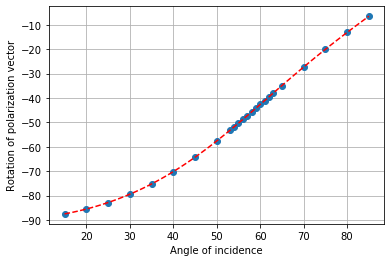

In [346]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

p_objt = linelikeexcel(df[X], theoreticalang)

x_line = np.linspace(min(df[X]), max(df[X]), 100)
y_linet = p_objt(x_line)

plt.plot(df[X], theoreticalang, 'o')
plt.plot(x_line,y_linet, 'r--')
plt.xlabel('Angle of incidence')
plt.ylabel('Rotation of polarization vector')

plt.grid()
plt.show()

### Polarization by quarterwave and halfwave plates

##### Quarterwave Plate

In [320]:
display(Latex('Minimum signal was observed to be $0.013 \ V$ at $66^{\circ}$.'))

f = codecs.open('4_pol_0.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p0 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['0'])


f = codecs.open('4_pol_30.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p30 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30'])

f = codecs.open('4_pol_45.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p45 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['45'])

f = codecs.open('4_pol_60.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p60 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['60'])

f = codecs.open('4_pol_90.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p90 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['90'])


angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=['𝜃'])
p4c = pd.concat([df, p0, p30, p45, p60, p90], axis=1)
p4c.style.set_caption("Polarizer set to different angles")

<IPython.core.display.Latex object>

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


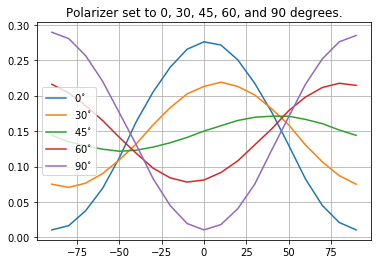

In [318]:
y = [p0['0'], p30['30'], p45['45'], p60['60'], p90['90']]
labels = ['$0^{\circ}$', '$30^{\circ}$', '$45^{\circ}$', '$60^{\circ}$', '$90^{\circ}$']
for y_arr, label in zip(y, labels):
    plt.plot(angles, y_arr, label=label)
plt.grid()
plt.legend()
plt.title('Polarizer set to 0, 30, 45, 60, and 90 degrees.')
plt.show()

In [321]:
f = codecs.open('4c_0.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p0 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['0'])


f = codecs.open('4c_30.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p30 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30'])

f = codecs.open('4c_45.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p45 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['45'])

f = codecs.open('4c_60.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p60 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['60'])

f = codecs.open('4c_90.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p90 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['90'])


angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=['𝜃'])
p4cd = pd.concat([df, p0, p30, p45, p60, p90], axis=1)
p4cd.style.set_caption("Quarterwave set to different angles")

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


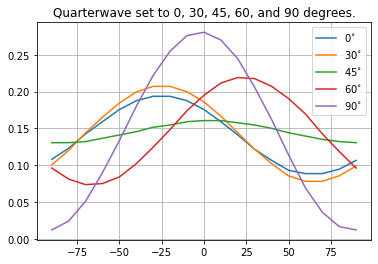

In [322]:
y = [p0['0'], p30['30'], p45['45'], p60['60'], p90['90']]
labels = ['$0^{\circ}$', '$30^{\circ}$', '$45^{\circ}$', '$60^{\circ}$', '$90^{\circ}$']
for y_arr, label in zip(y, labels):
    plt.plot(angles, y_arr, label=label)
plt.grid()
plt.legend()
plt.title('Quarterwave set to 0, 30, 45, 60, and 90 degrees.')
plt.show()

#### Halfwave plate

In [324]:
display(Latex('Minimum signal of the second waveplate added was observed at $33^{\circ}$.'))


f = codecs.open('4d_0.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p0 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['0'])


f = codecs.open('4d_15.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p30 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['15'])

f = codecs.open('4d_30.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p45 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30'])

f = codecs.open('4d_45.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p60 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['45'])

f = codecs.open('4d_30change.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p90 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30~'])


angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=['𝜃'])
p4cd = pd.concat([df, p0, p30, p45, p60, p90], axis=1)
p4cd.style.set_caption("Alignment of two quarterwave plates")

<IPython.core.display.Latex object>

In [325]:
y = [p0['0'], p30['15'], p45['30'], p60['45'], p90['30~']]
labels = ['$0^{\circ}$', '$15^{\circ}$', '$30^{\circ}$', '$45^{\circ}$', '$30~^{\circ}$']
for y_arr, label in zip(y, labels):
    plt.plot(angles, y_arr, label=label)
plt.grid()
plt.legend()
plt.title('Alignement of two quarter waveplates')
plt.show()